In [1]:
try:
  import qiskit
  import qiskit_aer
  import qiskit_nature
  import qiskit_ibm_runtime
  import pyscf
  import pylatexenc
except:
  !pip install qiskit qiskit-aer qiskit-ibm-runtime qiskit_nature pyscf pylatexenc

# General imports
import numpy as np

# Qiskit Runtime
from qiskit.primitives import Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [6]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper, InterleavedQubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeKolkata



from datetime import datetime


In [3]:
dist = 1.0

In [4]:
# IMPORTANT
def draw_orbitals(problem):
    # Draw orbitals (method provided by Max)
    print(f'Number of particles : {problem.num_particles}')
    print(f'Number of spatial orbitals : {problem.num_spatial_orbitals}')
    print(f'Orbital energies : {problem.orbital_energies}')

    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    for i in range(problem.num_spatial_orbitals):
        if problem.orbital_occupations[i] == 1:
            co = 'tab:blue'
        else:
            co = 'tab:green'

        ax.scatter(i,np.log10(np.abs(problem.orbital_energies[i])), s=15, c=co, marker='o')

    ax.set_xlabel('Orbital', fontsize=15)
    ax.set_ylabel(r'$\log\left(|E|\right)$', fontsize=15)

    ax.scatter(-2,2,s=15, c='tab:blue', marker='o', label='Occupied orbitals')
    ax.scatter(-2,2,s=15, c='tab:green', marker='o', label='Empty orbitals')
    ax.set_xlim(-0.2,problem.num_spatial_orbitals+0.2)
    ax.set_ylim(np.amin(np.log10(np.abs(problem.orbital_energies)))-0.2,
                np.amax(np.log10(np.abs(problem.orbital_energies)))+0.2)
    ax.legend(loc='best', fontsize=15)

def get_freezed_problem(properties, indexes = None):
    # Shortcut for the problem definition
    return FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=indexes
    ).transform(properties)



## other funcs copied

In [5]:
def exact_solver(qubit_op, problem):
  sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
  result = problem.interpret(sol)
  return result

## func for convenient experimental loop

In [7]:
def Experiment(
  molecule,
  orbitals_to_fix,
  optimizer=COBYLA(maxiter=3000, tol=0.0001),
  output_info=True,
  if_draw_orbitals=False,
):
  '''
  returns pair of (exact energy, vqe energy)
  '''
  print(f'= = = = = = = = = = = = = = = = = = = = = = = =\nExperiment started: {(datetime.now().time()).strftime("%H:%M:%S")}')  

  molecule = "".join(molecule)[:-1]
  driver = PySCFDriver(
      atom=molecule,
      unit=DistanceUnit.ANGSTROM,
      basis='sto3g',
      spin=0
  )
  properties_molecule = driver.run()
    
  problem = get_freezed_problem(properties_molecule, orbitals_to_fix)

  if (if_draw_orbitals):
    draw_orbitals(problem)
  if (output_info):
    print('. . . . . . . . . . . . . . . . . . .\n')
  
  # exact solver
  device = FakeKolkata()
  coupling_map = device.configuration().coupling_map
  noise_model = NoiseModel.from_backend(device)
  estimator = Estimator(
        backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
    )
  num_particles = problem.num_particles
  num_spatial_orbitals = problem.num_spatial_orbitals
  mapper = ParityMapper(num_particles=num_particles)
  # mapper = JordanWignerMapper()
  qubit_op = mapper.map(problem.second_q_ops()[0])
  
  exact_result = exact_solver(qubit_op, problem)
  if (output_info):
    print(exact_result)
    print(f'Exact solver done: {(datetime.now().time()).strftime("%H:%M:%S")}')
  
  
  # VQE
  init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
  # TODO: maybe try EfficientSU2 instead of UCCSD
  ansatz = UCCSD(
      num_spatial_orbitals, num_particles, mapper, initial_state=init_state
  )
  if (output_info):
    current_time = datetime.now().time()
    print(f'ansatz initialized, {current_time.strftime("%H:%M:%S")}')
    print(f'ansatz.depth = {ansatz.depth()}')
    print(f'num of qubits = {ansatz.num_qubits}')
  
  vqe = VQE(
        estimator,
        ansatz,
        optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )
  vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
  if (output_info):
    current_time = datetime.now().time()
    print(f'VQE compute_minimum_eigenvalue done, {current_time.strftime("%H:%M:%S")}')

  vqe_result = problem.interpret(vqe_calc)
  if (output_info):
    print(
      f"VQE Result: {vqe_result}\n",
      f"Exact Energy: {exact_result}\n"
    )
  return (exact_result, vqe_result)

In [11]:
lioh_dist_domain = np.linspace(0.1, 2, 30)

exact_energies = []
vqe_energies = []

for dist in lioh_dist_domain:
  molecule = [
    'H .0 .0 .0;',
    'H '+str(dist)+' .0 .0;',
    ]
  print(f"{dist = }")
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)
  exact_energies.append(exact_val)
  vqe_energies.append(vqe_val)
  
  

dist = 0.1
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 00:47:11
. . . . . . . . . . . . . . . . . . .



/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.581811338333
  - computed part:      -2.581811338333
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 5.2917721092
> Total ground state energy (Hartree): 2.709960770867
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.18897261  0.0  0.0]
 
Exact solver done: 00:47:11
ansatz initialized, 00:47:11
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:15
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.419566912222
  - computed part:      -2.419566912222
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 5.2917721092
> Total ground state energy (Hartree): 2.872205196978
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.18897261  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENERGY =

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.525419824379
  - computed part:      -2.525419824379
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 3.197112315975
> Total ground state energy (Hartree): 0.671692491596
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.31278226  0.0  0.0]
 
Exact solver done: 00:47:16
ansatz initialized, 00:47:16
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:20
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.406715667059
  - computed part:      -2.406715667059
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 3.197112315975
> Total ground state energy (Hartree): 0.790396648916
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.31278226  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENER

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.452136486808
  - computed part:      -2.452136486808
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 2.290468524878
> Total ground state energy (Hartree): -0.16166796193
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.4365919  0.0  0.0]
 
Exact solver done: 00:47:20
ansatz initialized, 00:47:20
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:24
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.359730583664
  - computed part:      -2.359730583664
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 2.290468524878
> Total ground state energy (Hartree): -0.069262058787
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.4365919  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENERG

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.370154964771
  - computed part:      -2.370154964771
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.784434781009
> Total ground state energy (Hartree): -0.585720183761
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.56040154  0.0  0.0]
 
Exact solver done: 00:47:25
ansatz initialized, 00:47:25
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:29
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.269099493366
  - computed part:      -2.269099493366
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.784434781009
> Total ground state energy (Hartree): -0.484664712357
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.56040154  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.285644345862
  - computed part:      -2.285644345862
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.461537058731
> Total ground state energy (Hartree): -0.82410728713
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.68421118  0.0  0.0]
 
Exact solver done: 00:47:29
ansatz initialized, 00:47:29
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:33
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.199370847625
  - computed part:      -2.199370847625
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.461537058731
> Total ground state energy (Hartree): -0.737833788894
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.68421118  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.202273348913
  - computed part:      -2.202273348913
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.237591864248
> Total ground state energy (Hartree): -0.964681484664
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.80802083  0.0  0.0]
 
Exact solver done: 00:47:34
ansatz initialized, 00:47:34
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:38
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.132823022122
  - computed part:      -2.132823022122
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.237591864248
> Total ground state energy (Hartree): -0.895231157874
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.80802083  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.121785638055
  - computed part:      -2.121785638055
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.073156581586
> Total ground state energy (Hartree): -1.048629056468
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.93183047  0.0  0.0]
 
Exact solver done: 00:47:38
ansatz initialized, 00:47:38
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:42
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.045888707736
  - computed part:      -2.045888707736
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 1.073156581586
> Total ground state energy (Hartree): -0.97273212615
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.93183047  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.044864188738
  - computed part:      -2.044864188738
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.947292538067
> Total ground state energy (Hartree): -1.097571650672
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.05564011  0.0  0.0]
 
Exact solver done: 00:47:43
ansatz initialized, 00:47:43
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:47
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.957303430445
  - computed part:      -1.957303430445
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.947292538067
> Total ground state energy (Hartree): -1.010010892378
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.05564011  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.971779751676
  - computed part:      -1.971779751676
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.847852989872
> Total ground state energy (Hartree): -1.123926761804
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.17944975  0.0  0.0]
 
Exact solver done: 00:47:48
ansatz initialized, 00:47:48
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:51
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.907812124702
  - computed part:      -1.907812124702
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.847852989872
> Total ground state energy (Hartree): -1.05995913483
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.17944975  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.902692177073
  - computed part:      -1.902692177073
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.767306955834
> Total ground state energy (Hartree): -1.135385221239
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.3032594  0.0  0.0]
 
Exact solver done: 00:47:52
ansatz initialized, 00:47:52
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:47:56
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.842957668332
  - computed part:      -1.842957668332
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.767306955834
> Total ground state energy (Hartree): -1.075650712498
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.3032594  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENER

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.837706436382
  - computed part:      -1.837706436382
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.700736945967
> Total ground state energy (Hartree): -1.136969490415
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.42706904  0.0  0.0]
 
Exact solver done: 00:47:56
ansatz initialized, 00:47:56
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:00
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.778220098446
  - computed part:      -1.778220098446
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.700736945967
> Total ground state energy (Hartree): -1.077483152479
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.42706904  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.776839708544
  - computed part:      -1.776839708544
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.644795761205
> Total ground state energy (Hartree): -1.132043947339
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.55087868  0.0  0.0]
 
Exact solver done: 00:48:01
ansatz initialized, 00:48:01
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:04
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.725147082839
  - computed part:      -1.725147082839
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.644795761205
> Total ground state energy (Hartree): -1.080351321634
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.55087868  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.720002487621
  - computed part:      -1.720002487621
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.597126035668
> Total ground state energy (Hartree): -1.122876451952
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.67468832  0.0  0.0]
 
Exact solver done: 00:48:05
ansatz initialized, 00:48:05
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:09
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.649976345855
  - computed part:      -1.649976345855
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.597126035668
> Total ground state energy (Hartree): -1.052850310186
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.67468832  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.667021471372
  - computed part:      -1.667021471372
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.556019533213
> Total ground state energy (Hartree): -1.111001938159
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.79849797  0.0  0.0]
 
Exact solver done: 00:48:09
ansatz initialized, 00:48:09
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:13
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.625374541929
  - computed part:      -1.625374541929
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.556019533213
> Total ground state energy (Hartree): -1.069355008715
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.79849797  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.617686087399
  - computed part:      -1.617686087399
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.52020810565
> Total ground state energy (Hartree): -1.097477981749
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.92230761  0.0  0.0]
 
Exact solver done: 00:48:14
ansatz initialized, 00:48:14
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:17
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.581362469886
  - computed part:      -1.581362469886
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.52020810565
> Total ground state energy (Hartree): -1.061154364236
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.92230761  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENER

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.571791529957
  - computed part:      -1.571791529957
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.488730545117
> Total ground state energy (Hartree): -1.083060984839
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.04611725  0.0  0.0]
 
Exact solver done: 00:48:18
ansatz initialized, 00:48:18
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:22
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.545691468123
  - computed part:      -1.545691468123
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.488730545117
> Total ground state energy (Hartree): -1.056960923006
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.04611725  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.52916281541
  - computed part:      -1.52916281541
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.460845018519
> Total ground state energy (Hartree): -1.068317796891
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.16992689  0.0  0.0]
 
Exact solver done: 00:48:23
ansatz initialized, 00:48:23
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:26
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.48004727859
  - computed part:      -1.48004727859
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.460845018519
> Total ground state energy (Hartree): -1.019202260071
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.16992689  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENERGY

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.489658739731
  - computed part:      -1.489658739731
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.435969861269
> Total ground state energy (Hartree): -1.053688878462
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.29373654  0.0  0.0]
 
Exact solver done: 00:48:27
ansatz initialized, 00:48:27
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:30
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.431501771849
  - computed part:      -1.431501771849
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.435969861269
> Total ground state energy (Hartree): -0.99553191058
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.29373654  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.453162761217
  - computed part:      -1.453162761217
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.413642563792
> Total ground state energy (Hartree): -1.039520197425
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.41754618  0.0  0.0]
 
Exact solver done: 00:48:31
ansatz initialized, 00:48:31
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:35
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.427567533393
  - computed part:      -1.427567533393
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.413642563792
> Total ground state energy (Hartree): -1.013924969601
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.41754618  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.419569123337
  - computed part:      -1.419569123337
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.393490746582
> Total ground state energy (Hartree): -1.026078376755
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.54135582  0.0  0.0]
 
Exact solver done: 00:48:36
ansatz initialized, 00:48:36
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:39
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.387038289083
  - computed part:      -1.387038289083
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.393490746582
> Total ground state energy (Hartree): -0.993547542502
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.54135582  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.388770080318
  - computed part:      -1.388770080318
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.375211225347
> Total ground state energy (Hartree): -1.013558854971
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.66516547  0.0  0.0]
 
Exact solver done: 00:48:40
ansatz initialized, 00:48:40
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:44
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.360675312937
  - computed part:      -1.360675312937
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.375211225347
> Total ground state energy (Hartree): -0.98546408759
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.66516547  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.360646956997
  - computed part:      -1.360646956997
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.358554652259
> Total ground state energy (Hartree): -1.002092304738
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.78897511  0.0  0.0]
 
Exact solver done: 00:48:44
ansatz initialized, 00:48:44
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:48
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.329626000905
  - computed part:      -1.329626000905
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.358554652259
> Total ground state energy (Hartree): -0.971071348646
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.78897511  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.335065537928
  - computed part:      -1.335065537928
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.343314074199
> Total ground state energy (Hartree): -0.991751463729
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.91278475  0.0  0.0]
 
Exact solver done: 00:48:49
ansatz initialized, 00:48:49
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:52
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.291080343445
  - computed part:      -1.291080343445
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.343314074199
> Total ground state energy (Hartree): -0.947766269247
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.91278475  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.311875187098
  - computed part:      -1.311875187098
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.329316290058
> Total ground state energy (Hartree): -0.98255889704
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.03659439  0.0  0.0]
 
Exact solver done: 00:48:53
ansatz initialized, 00:48:53
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:48:57
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.281564588067
  - computed part:      -1.281564588067
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.329316290058
> Total ground state energy (Hartree): -0.952248298009
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.03659439  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENE

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.290910774926
  - computed part:      -1.290910774926
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.316415239519
> Total ground state energy (Hartree): -0.974495535407
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.16040404  0.0  0.0]
 
Exact solver done: 00:48:58
ansatz initialized, 00:48:58
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:01
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.264415677608
  - computed part:      -1.264415677608
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.316415239519
> Total ground state energy (Hartree): -0.948000438089
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.16040404  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.271996499113
  - computed part:      -1.271996499113
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.304486887236
> Total ground state energy (Hartree): -0.967509611878
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.28421368  0.0  0.0]
 
Exact solver done: 00:49:02
ansatz initialized, 00:49:02
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:06
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.252586677327
  - computed part:      -1.252586677327
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.304486887236
> Total ground state energy (Hartree): -0.948099790091
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.28421368  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.254950775094
  - computed part:      -1.254950775094
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.293425222116
> Total ground state energy (Hartree): -0.961525552978
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.40802332  0.0  0.0]
 
Exact solver done: 00:49:06
ansatz initialized, 00:49:06
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:10
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.23295946447
  - computed part:      -1.23295946447
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.293425222116
> Total ground state energy (Hartree): -0.939534242354
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.40802332  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENER

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.239591465225
  - computed part:      -1.239591465225
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.283139098094
> Total ground state energy (Hartree): -0.956452367132
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.53183296  0.0  0.0]
 
Exact solver done: 00:49:11
ansatz initialized, 00:49:11
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:14
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.218131035443
  - computed part:      -1.218131035443
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.283139098094
> Total ground state energy (Hartree): -0.934991937349
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.53183296  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.225740827651
  - computed part:      -1.225740827651
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.273549716875
> Total ground state energy (Hartree): -0.952191110776
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.65564261  0.0  0.0]
 
Exact solver done: 00:49:15
ansatz initialized, 00:49:15
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:19
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.193275523313
  - computed part:      -1.193275523313
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.273549716875
> Total ground state energy (Hartree): -0.919725806439
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.65564261  0.0  0.0]
 
 Exact Energy: === GROUND STATE EN

/tmp/ipykernel_82174/4076771906.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_82174/4178136630.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.213229717636
  - computed part:      -1.213229717636
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.26458860546
> Total ground state energy (Hartree): -0.948641112176
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.77945225  0.0  0.0]
 
Exact solver done: 00:49:20
ansatz initialized, 00:49:20
ansatz.depth = 1
num of qubits = 2
VQE compute_minimum_eigenvalue done, 00:49:23
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.185186350093
  - computed part:      -1.185186350093
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.26458860546
> Total ground state energy (Hartree): -0.920597744633
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.77945225  0.0  0.0]
 
 Exact Energy: === GROUND STATE ENER

In [12]:
exact_energies_fixed = []
vqe_energies_fixed = []
for el, vl in zip(exact_energies,vqe_energies):
  exact_energies_fixed.append(el.electronic_energies[0] + el.nuclear_repulsion_energy)
  vqe_energies_fixed.append(vl.electronic_energies[0] + vl.nuclear_repulsion_energy)
  

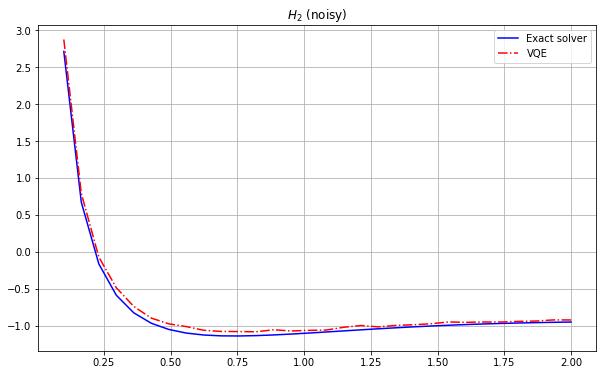

In [15]:
import matplotlib.pyplot as plt

index = 0

plt.figure(figsize=(10, 6))
plt.plot(lioh_dist_domain[index:], exact_energies_fixed[index:], label='Exact solver', linestyle='-', color='b')
plt.plot(lioh_dist_domain[index:], vqe_energies_fixed[index:], label='VQE', linestyle='dashdot', color='r')
plt.title('$H_2$ (noisy)')
plt.grid()
plt.legend(loc='best')
plt.show()

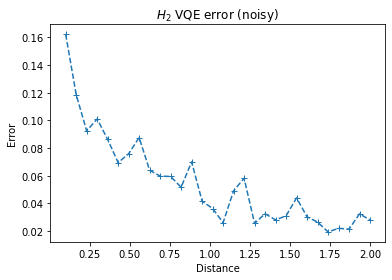

In [17]:
# The error commited at every step remain small

fig, ax = plt.subplots()
# ax.plot(lioh_dist_domain,np.log10(np.abs([vqe_energies[i] - exact_energies_fixed[i] for i in range(len(lioh_dist_domain))])),'+--')
ax.plot(lioh_dist_domain,(np.abs([vqe_energies[i].electronic_energies[0] - exact_energies[i].electronic_energies[0] for i in range(len(lioh_dist_domain))])),'+--')

ax.set_xlabel("Distance")
ax.set_ylabel("Error")
plt.title('$H_2$ VQE error (noisy)')

plt.draw()

In [23]:
np.min(exact_energies_fixed)  # H2

np.float64(-1.1373057587800393)

In [61]:
def Experiment_only_exact_solver(
  molecule,
  orbitals_to_fix,
  optimizer=COBYLA(maxiter=100, tol=0.0001),
  output_info=True,
  if_draw_orbitals=False,
):
  '''
  returns pair of (exact energy, vqe energy)
  '''
  print(f'= = = = = = = = = = = = = = = = = = = = = = = =\nExperiment started: {(datetime.now().time()).strftime("%H:%M:%S")}')  

  molecule = "".join(molecule)[:-1]
  # if (output_info):
  #   print('Molecule info:')
  #   print(molecule)
  driver = PySCFDriver(
      atom=molecule,
      unit=DistanceUnit.ANGSTROM,
      basis='sto3g',
      spin=0
  )
  properties_molecule = driver.run()
  # if (output_info):
  #   print(properties_molecule.num_spatial_orbitals)
  #   print(properties_molecule.orbital_occupations)
  #   print(properties_molecule.num_particles)
    
  problem = get_freezed_problem(properties_molecule, orbitals_to_fix)
  if (if_draw_orbitals):
    draw_orbitals(problem)
  # if (output_info):
  #   print(f'{problem.num_spatial_orbitals = }')
  #   print(f"{problem.orbital_occupations = }")
  #   print(f'{problem.num_particles}')
  if (output_info):
    print('. . . . . . . . . . . . . . . . . . .\n')
  
  # exact solver
  estimator = Estimator(approximation=True)
  num_particles = problem.num_particles
  num_spatial_orbitals = problem.num_spatial_orbitals
  mapper = ParityMapper(num_particles=num_particles)
  # mapper = JordanWignerMapper()
  qubit_op = mapper.map(problem.second_q_ops()[0])
  
  exact_result = exact_solver(qubit_op, problem)
  if (output_info):
    print(exact_result)
    print(f'Exact solver done: {(datetime.now().time()).strftime("%H:%M:%S")}')
  return exact_result
  

In [82]:
lioh_dist_domain_2 = np.linspace(2, 3, 10)

exact_energies_tmp = []
result_array = []
exact_energies_total = []
exact_energies_electronic = []

for dist in lioh_dist_domain_2:
    molecule_lioh = [
    'O .0 .0 .0;',
    'H .0 '+'1.0'+' .0;',
    'Li .0 -'+str(dist)+' .0;',
    ]
    print(f"{dist = }")
    val = Experiment_only_exact_solver(molecule=molecule_lioh, orbitals_to_fix=[2, 10], if_draw_orbitals=False)
    exact_energies_electronic.append(val.electronic_energies[0] + val.nuclear_repulsion_energy)
    exact_energies_total.append(val.total_energies)
    result_array.append(val)
  
  

dist = 2.0
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 18:48:56
. . . . . . . . . . . . . . . . . . .

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -92.841870005469
  - computed part:      -10.99959934314
  - FreezeCoreTransformer extracted energy part: -81.842270662329
~ Nuclear repulsion energy (Hartree): 11.11272142932
> Total ground state energy (Hartree): -81.729148576149
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  -9.44863062  0.0]
 
Exact solver done: 18:49:00
dist = 2.111111111111111
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 18:49:00
. . . . . . . . . . . . . . . . . . .

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -92.467252516752
  - computed part:      -10.915555343509
  - FreezeCoreTransformer extracted energy part: -81.551697173242
~ Nuclear repulsion energy (Hartree): 10.759605057372
> Total ground state energy 

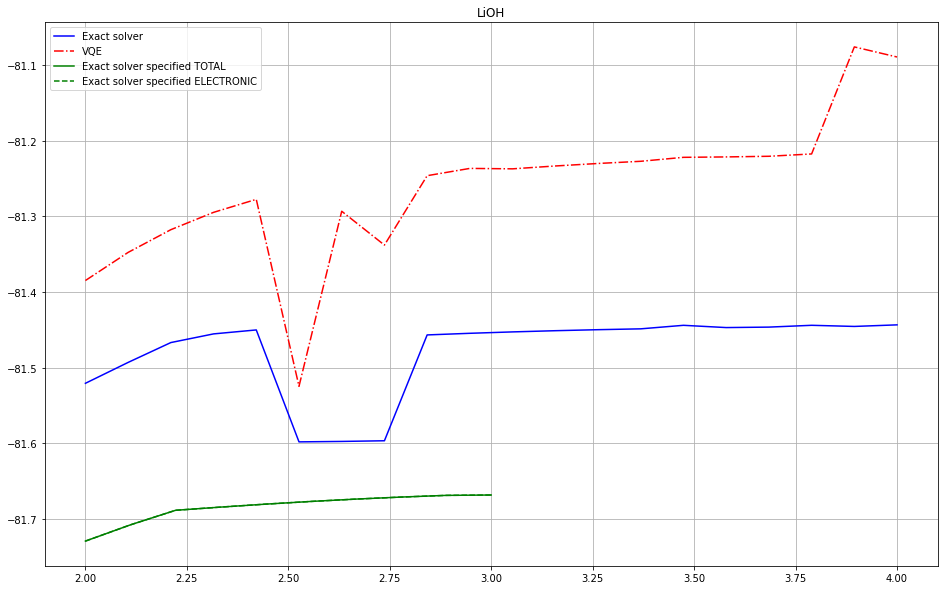

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.plot(lioh_dist_domain, exact_energies_fixed, label='Exact solver', linestyle='-', color='b')
plt.plot(lioh_dist_domain, vqe_energies, label='VQE', linestyle='dashdot', color='r')
plt.plot(lioh_dist_domain_2, exact_energies_total, label='Exact solver specified TOTAL', color='g')
plt.plot(lioh_dist_domain_2, exact_energies_electronic, label='Exact solver specified ELECTRONIC', linestyle='--', color='g')
plt.title('LiOH')
plt.grid()
plt.legend(loc='best')
plt.show()

In [68]:
exact_energies_tmp

[array([-85.87524896]),
 array([-85.87524896]),
 array([-85.87524896]),
 array([-85.87524896]),
 array([-85.87524896])]

In [ ]:
import pandas as pd

LiOH_distance_experiment_dataframe = pd.DataFrame({
    'distance': lioh_dist_domain,
    'exact_energies': exact_energies,
    'vqe_energies': vqe_energies,
})
LiOH_distance_experiment_dataframe.to_csv('./data/LiOH_distance_experiment.csv')

# other things

Number of particles : (3, 3)
Number of spatial orbitals : 7
Orbital energies : [-0.47335055 -0.4329751  -0.4329751   0.10892243  0.32326215  0.32326215
  0.36535371]


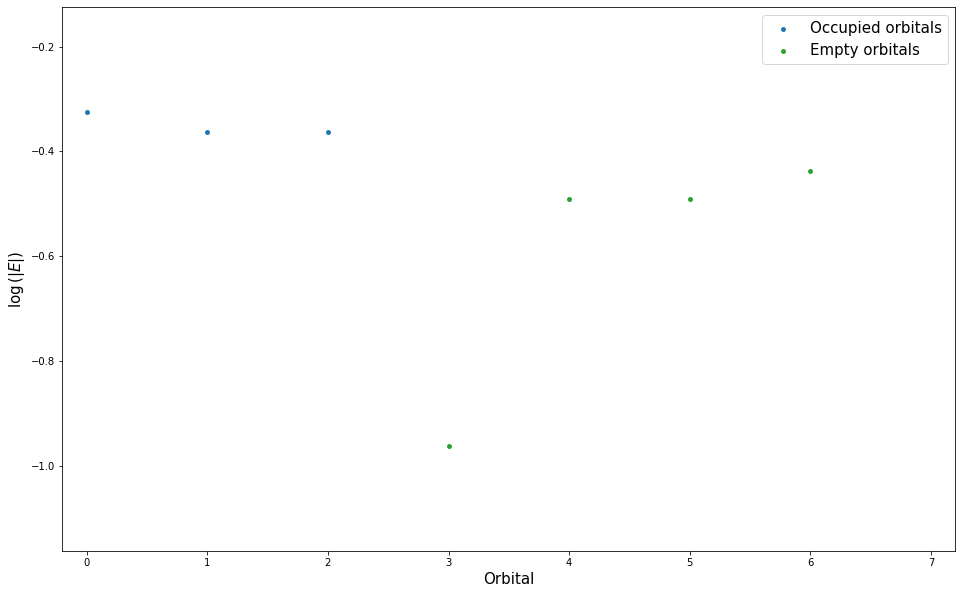

In [16]:
draw_orbitals(get_freezed_problem(properties_lioh, [2,10]))

In [ ]:
def get_freezed_problem(properties, indexes = None):
    return FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=indexes
    ).transform(properties)

In [ ]:
fermionic_op = properties.hamiltonian.second_q_op()
# mapper = JordanWignerMapper() #12
mapper = ParityMapper(num_particles=properties.num_particles) #10
# mapper = InterleavedQubitMapper(JordanWignerMapper()) #12
# mapper = BravyiKitaevMapper() #12

hamiltonian = mapper.map(fermionic_op)

print(hamiltonian.num_qubits)

20


In [ ]:
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["Li", "H"],
    coords=([0.0, 0.0, 0.0], [1.0, 0.0, 0.0]),
    # multiplicity=1,  # = 2*spin + 1
    # charge=0,
)

driver = PySCFDriver.from_molecule(molecule)

# Get properties
properties_lih = driver.run()
print(properties_lih.num_particles)
print(properties_lih.num_spatial_orbitals)
print(properties_lih.num_spin_orbitals) # 1s2 2s2 2p6 3s2 3p6
print(properties_lih.orbital_occupations)

(2, 2)
6
12
[1. 1. 0. 0. 0. 0.]


Number of particles : (2, 2)
Number of spatial orbitals : 6
Orbital energies : [-2.37089933 -0.31665704  0.07684843  0.15793876  0.15793876  0.61299931]


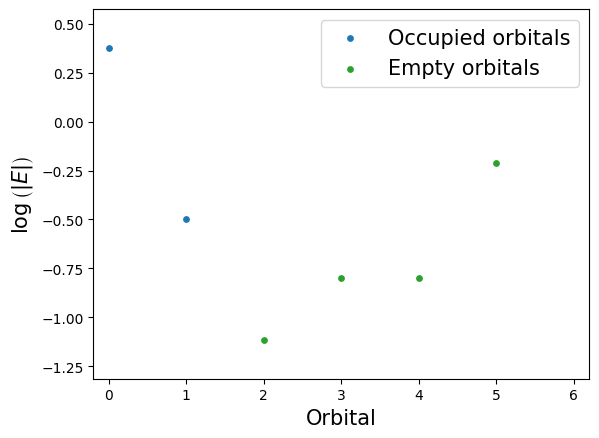

In [ ]:
draw_obritals(properties_lih)

[1. 0. 0. 0. 0.]
Number of particles : (1, 1)
Number of spatial orbitals : 5
Orbital energies : [-0.31665704  0.07684843  0.15793876  0.15793876  0.61299931]


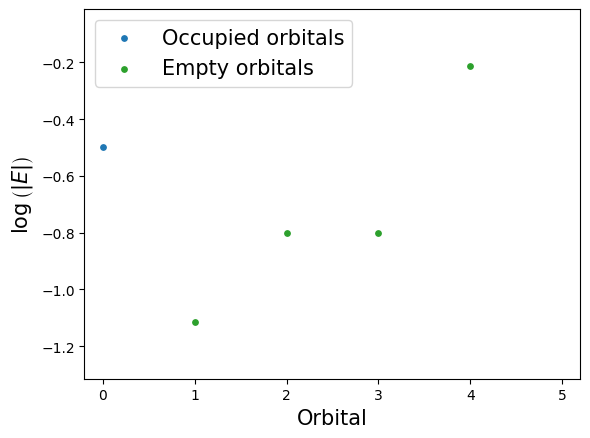

In [ ]:
problem_lih_min = FreezeCoreTransformer(
        freeze_core=True
    ).transform(properties_lih)

print(problem_lih_min.orbital_occupations)
draw_orbitals(problem_lih_min)

In [ ]:
# draw_obritals(problem_lih_min)

In [ ]:
# print(fermionic_op)
print(problem.num_particles)

(2, 2)


In [ ]:
# mapper = JordanWignerMapper() #12
mapper = ParityMapper(num_particles=problem.num_particles) #10
# mapper = InterleavedQubitMapper(JordanWignerMapper()) #12
# mapper = BravyiKitaevMapper() #12

hamiltonian = mapper.map(fermionic_op)

print(hamiltonian.num_qubits)

10


In [ ]:
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIYZZZYI', 'IIIIIIIIIIIIYZZZYZ', 'IIIIIIIIIIIIXZZZXI', 'IIIIIIIIIIIIXZZZXZ', 'IIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIYZZZYII', 'IIIIIIIIIIIYZZZYIZ', 'IIIIIIIIIIIXZZZXII', 'IIIIIIIIIIIXZZZXIZ', 'IIIIIIIIIIYZZZZYII', 'IIIIIIIIIIYZZZZYIZ', 'IIIIIIIIIIXZZZZXII', 'IIIIIIIIIIXZZZZXIZ', 'IIIIIIIIIYZZZZZYII', 'IIIIIIIIIYZZZZZYIZ', 'IIIIIIIIIXZZZZZXII', 'IIIIIIIIIXZZZZZXIZ', 'IIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIYZZYIII', 'IIIIIIIIIIIYZZYIIZ', 'IIIIIIIIIIIXZZXIII', 'IIIIIIIIIIIXZZXIIZ', 'IIIIIIIIIIYZZZYIII', 'IIIIIIIIIIYZZZYIIZ', 'IIIIIIIIIIXZZZXIII', 'IIIIIIIIIIXZZZXIIZ', 'IIIIIIIIIYZZZZYIII', 'IIIIIIIIIYZZZZYIIZ', 'IIIIIIIIIXZZZZXIII', 'IIIIIIIIIXZZZZXIIZ', 'IIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIYZYIIII', 'IIIIIIIIIIIYZYIIIZ', 'IIIIIIIIIIIXZXIIII', 'IIIIIIIIIIIXZXIIIZ', 'IIIIIIIIIIYZZYIIII', 'IIIIIIIIIIYZZYIIIZ', 'IIIIIIIIIIXZZXII

In [ ]:
HF_state = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals,
                       num_particles=problem.num_particles,
                       qubit_mapper=mapper)

ansatz = UCCSD(num_particles=problem.num_particles,
              num_spatial_orbitals= problem.num_spatial_orbitals,
              qubit_mapper=mapper,
              initial_state=HF_state)

ansatz.decompose().draw("mpl", style="iqp")

ValueError: Image size of 2210x73527 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2210.55x73527.6 with 1 Axes>

In [ ]:
num_params = ansatz.num_parameters
num_params

92

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [ ]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [ ]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(mapper, numpy_solver)
res_Exact = calc.solve(problem)

print(res_Exact)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.371991912791
  - computed part:      -9.371991912791
~ Nuclear repulsion energy (Hartree): 1.58753163276
> Total ground state energy (Hartree): -7.784460280031
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.88972612  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [3.748259153591  0.0  0.0]
    - computed part:      [3.748259153591  0.0  0.0]
  > Dipole moment (a.u.): [-1.858533033591  0.0  0.0]  Total: 1.858533033591
                 (debye): [-4.723919333422  0.0  0.0]  Total: 4.723919333422
 


In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)

estimator = Estimator()
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
        options = {'maxiter':15, 'tol':0.01}
    )

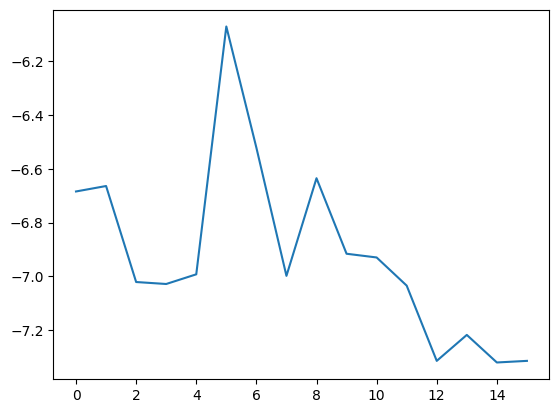

In [ ]:
plt.plot(callback_dict['cost_history'])

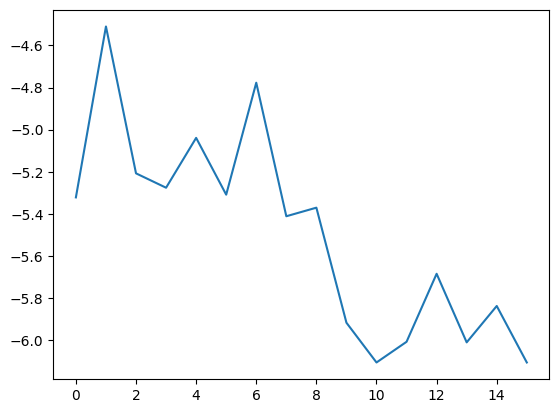

In [ ]:
plt.plot(callback_dict['cost_history'])

In [ ]:
min_energy = []
exact_energy = []

for dist in np.linspace(0.1,2,20):

    molecule = [
    'Li .0 .0 .0;',
    'H '+str(dist)+' .0 .0;',
    ]
    molecule = "".join(molecule)[:-1]

    driver = PySCFDriver(
        atom=molecule,
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
        spin=0
    )
    problem = driver.run()
    fermionic_op = problem.hamiltonian.second_q_op()
    hamiltonian = mapper.map(fermionic_op)

    callback_dict = {
            "prev_vector": None,
            "iters": 0,
            "cost_history": [],
        }

    x0 = 2 * np.pi * np.random.random(num_params)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    res = minimize(
            cost_func,
            x0,
            args=(ansatz, hamiltonian, estimator),
            method="cobyla",
            callback=callback,
            options = {'maxiter':5000, 'tol':0.001}
        )

    exact_energy.append(calc.solve(problem))
    min_energy.append(res.fun)